In [1]:
import os
import json
import librosa
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple
import numpy as np
from glob import glob
from tqdm import tqdm
import random

In [3]:
target = json.load(open("/home/virgile/data/vad_data/1246-124548-0018.json", 'r'))
print(json.dumps(target, indent=4))

{
    "speech_segments": [
        {
            "start_time": 0.21,
            "end_time": 0.42
        },
        {
            "start_time": 0.42,
            "end_time": 0.71
        },
        {
            "start_time": 0.71,
            "end_time": 1.1099999999999999
        },
        {
            "start_time": 1.11,
            "end_time": 1.61
        },
        {
            "start_time": 1.64,
            "end_time": 1.89
        },
        {
            "start_time": 1.9,
            "end_time": 2.32
        },
        {
            "start_time": 2.32,
            "end_time": 2.82
        },
        {
            "start_time": 2.82,
            "end_time": 3.3099999999999996
        },
        {
            "start_time": 3.52,
            "end_time": 3.75
        },
        {
            "start_time": 3.75,
            "end_time": 3.97
        },
        {
            "start_time": 3.97,
            "end_time": 4.25
        },
        {
            "start_time": 4.25,
  

In [89]:
def get_df_from_json(json_path:str, min_length:float=0.01)->pd.DataFrame:
    """
    Generates a Dataframe containing utterrances infos from json annotations

    Args:
        json_path (str): path to json file containing annotations

    Returns:
        pd.DataFrame: Annotation in the form of Dataframe
    """
    data = json.load(open(json_path, 'r'))

    speech_df = pd.DataFrame(data['speech_segments'])
    speech_df['utt_time'] = ""
    speech_df['speech'] = 1
    speech_df['start_time'] = np.round(speech_df['start_time'].astype(float),3)
    speech_df['end_time'] = np.round(speech_df['end_time'].astype(float),3)

    utt_times = []
    # Add start and stops for non_speech:
    for i in range(len(speech_df)-1):
        if abs(speech_df.iloc[i]['end_time'] - speech_df.iloc[i+1]['start_time']) > 0.01:
            speech_df = speech_df.append({'start_time':speech_df.iloc[i]['end_time'], 
                                          'end_time':speech_df.iloc[i+1]['start_time'],
                                          'speech':0}, ignore_index=True)

    # Add first row
    if speech_df.iloc[0].start_time != 0.0:
        speech_df = speech_df.append({'start_time':0.0, 
                                      'end_time':speech_df.iloc[0]['start_time'],
                                      'speech':0}, ignore_index=True)

    # Add utterances times
    utt_times = []
    for i in range(len(speech_df)):
        utt_times.append(np.round(speech_df.iloc[i]['end_time'] - speech_df.iloc[i]['start_time'], 3))
    speech_df['utt_time'] = utt_times

    # Sort DF
    speech_df = speech_df.sort_values(by='start_time').reset_index(drop=True)
    # Add audio ID
    speech_df['audio_id'] = json_path.replace('.json', '.wav')


    return speech_df

In [90]:
def get_consolidated_dataframe(json_data_path:str)->pd.DataFrame:
    """
    Get consolidated data for speech and non-speech utterances in the form of a Dataframe.
    - For each json annotation, get its corresponding Dataframe
    - Concatenate all Dataframe

    Args:
        json_data_path (str): Path to folder containing JSON annotations

    Returns:
        pd.DataFrame: Consolidated Dataframe
    """

    list_json = glob(json_data_path + '*.json')
    
    speech_dfs = []
    for k in tqdm(list_json):
        speech_df = get_df_from_json(k)
        speech_dfs.append(speech_df)

    speech_df = pd.concat(speech_dfs).reset_index(drop=True)
    
    return speech_df

In [7]:
speech_df = get_consolidated_dataframe(json_data_path='/home/virgile/data/vad_data/')

100%|██████████| 957/957 [00:19<00:00, 47.96it/s]


In [8]:
print(speech_df[speech_df['speech']==1].utt_time.sum())
print(speech_df[speech_df['speech']==0].utt_time.sum())


9519.91
1701.56


In [194]:
# Let's add 7819 seconds of (noisy) silence
tracklist = glob('/home/virgile/data/vad_data/*.wav')
len(tracklist)

noise_files = glob('/data/Noise_LibriSpeech/*')
len(noise_files) / len(tracklist)

4.112852664576803

In [9]:
t = "/home/virgile/data/vad_data/19-198-0003.wav"
signal, sr = librosa.load(t, sr=16000)

In [91]:
df = get_df_from_json("/home/virgile/data/vad_data/19-198-0003.json")
df.head()

,start_time,end_time,utt_time,speech,audio_id
0,0.00,0.53,0.53,0.0,/home/virgile/data/vad_data/19-198-0003.wav
1,0.53,0.65,0.12,1.0,/home/virgile/data/vad_data/19-198-0003.wav
2,0.65,1.07,0.42,1.0,/home/virgile/data/vad_data/19-198-0003.wav
3,1.07,1.08,0.01,0.0,/home/virgile/data/vad_data/19-198-0003.wav
4,1.08,1.30,0.22,1.0,/home/virgile/data/vad_data/19-198-0003.wav


In [195]:
def add_noise_to_track(audio_path):
    # Load original signal
    signal, sr = librosa.load(audio_path, sr=16000)
    # get non-speech times
    df = get_df_from_json(audio_path.replace('.wav', '.json'))
    time_idx = sorted(random.choices(list(df[df.speech == 0].index), k=4))
    # Add noises
    noise_file_idx = 0
    for idx in time_idx: 
        noise, sr = librosa.load(noise_files[noise_file_idx], sr=16000)
        noise_len = len(noise)/sr
        noise = noise - np.mean(noise)

        time_sample = int(df.iloc[idx].start_time*sr)
        signal = np.concatenate([signal[:time_sample], noise, signal[time_sample:]])
        noise_file_idx += 1

        # modify df
        df.loc[df.index>idx, 'start_time'] += noise_len
        df.loc[df.index==idx, 'utt_time'] += noise_len
        df.loc[df.index>=idx, 'end_time'] += noise_len

    return signal, df

In [196]:
import soundfile as sf

In [197]:
for t in tqdm(tracklist):
    signal, df = add_noise_to_track(t)
    sf.write('/home/virgile/data/vad_data_augmented/{}'.format(os.path.basename(t)), signal, samplerate=16000)
    df.to_csv('/home/virgile/data/vad_data_augmented/{}'.format(os.path.basename(t).replace('.wav', '.csv')), index=False)
        

100%|██████████| 957/957 [00:30<00:00, 31.07it/s]


In [206]:
df

,start_time,end_time,utt_time,speech,audio_id
0,0.000,0.140,0.140,0.0,/home/virgile/data/vad_data/1081-125237-0037.wav
1,0.140,0.290,0.150,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
2,0.290,0.430,0.140,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
3,0.430,0.610,0.180,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
4,0.610,1.050,0.440,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
5,1.050,1.090,0.040,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
6,1.090,2.660,1.570,0.0,/home/virgile/data/vad_data/1081-125237-0037.wav
7,2.660,2.780,0.120,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
8,2.780,3.060,0.280,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav
9,3.060,3.410,0.350,1.0,/home/virgile/data/vad_data/1081-125237-0037.wav


In [207]:
def get_gt_plot_waveform(signal, df):
    gt_plot = np.zeros_like(signal)

    cur_sample = int(df.iloc[0].start_time * 16000)
    for i in df.index:
        utt_len = int(df.iloc[i].utt_time * 16000)

        gt_plot[cur_sample:cur_sample+utt_len] = df.iloc[i].speech
        cur_sample += utt_len

    plt.plot(gt_plot)
    plt.plot(signal)
    

In [239]:
tracklist = glob('/home/virgile/data/vad_data_augmented/*.wav')


### Alignement mel_spectro & annotation.

In [217]:
import torchaudio
nfft = 400
hop_lenght = 160 # 10ms @ 16kHz
n_mels = 64
melspec = torchaudio.transforms.MelSpectrogram(n_fft=nfft, hop_length=hop_lenght, n_mels=n_mels)

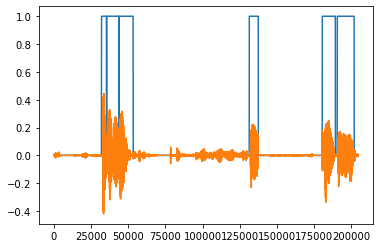

In [245]:
t = random.choice(tracklist)
signal, sr = librosa.load(t, sr=16000)
df = pd.read_csv(t.replace('.wav', '.csv'))
get_gt_plot_waveform(signal, df)

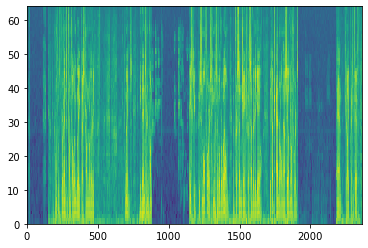

In [167]:
waveform, sample_rate = torchaudio.load(t)
mel = melspec(waveform)
plt.pcolormesh(np.log(mel.numpy()[0]))

In [192]:
waveform, sr = torchaudio.load(t)

In [193]:
waveform.shape

torch.Size([1, 399200])

In [255]:
def get_plot_spectro(audio_path):
    waveform, sr = torchaudio.load(audio_path)
    df = pd.read_csv(audio_path.replace('.wav', '.csv'))
    mel = melspec(waveform)

    gt_plot = np.zeros((mel.shape[-1]))

    cur_frame = 0
    for i in df.index:
        utt_len = int(df.iloc[i].utt_time / 0.01) # 10ms hop length

        gt_plot[cur_frame:cur_frame+utt_len] = df.iloc[i].speech  * 40
        cur_frame += utt_len

    plt.plot(gt_plot, color='red')
    plt.pcolormesh(np.log(mel.numpy()[0]))

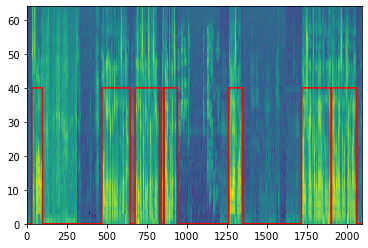

In [261]:
get_plot_spectro(random.choice(tracklist))